# Report Section

### Data Preprocessing

Rather than preprocessing the data once and then tuning the model’s hyperparameters, I instead built a pipeline so that I could tune the preprocessing steps as well. After 448 iterations of RandomSearchCV (reasoning for 448 is explained in code), the best model found (as scored by the custom scorer in code) utilised a binary vectorizer and a random oversampler . Furthermore, it had an alpha value of 0.01, removed stop words, and incorporated an ngram range of (1, 3). The motivation behind this approach was due to the impact that the preprocessing can have on the effectiveness of the Naive Bayes model. 


### Model Improvements

To enhance the performance of the Naive Bayes model, I implemented several targeted strategies, closely aligning with the insights gained during the data preprocessing phase:

- Vectorization Technique: The model employed a binary vectorizer. This approach differs from standard count vectorization by merely acknowledging the presence or absence of terms rather than their frequency. This method is particularly effective in contexts where the occurrence of words is more significant than their count.

- Oversampling Strategy: To address potential class imbalances in the dataset, a random oversampler was used. This technique helps in equalizing the distribution of classes by increasing the number of instances in the minority class, thus providing a more balanced training dataset for the model.

- Hyperparameter Tuning: The model's hyperparameters were fine-tuned, with an emphasis on the Laplace smoothing parameter (alpha). An optimal alpha value of 0.01 was determined, which plays a crucial role in managing the model's sensitivity to feature variance.

- N-gram Range: The preprocessing incorporated an n-gram range of (1, 3). This range enables the model to consider unigrams, bigrams, and trigrams, thereby capturing more context and relationships between words in the text, which is crucial for understanding the nuances in the data.

- Stop Words Removal: The removal of stop words was part of the preprocessing steps. This approach helps in reducing noise in the data, allowing the model to focus on more meaningful words which are likely to contribute more towards the classification task.

These improvements collectively aim to refine the model’s ability to understand and classify the textual data more accurately, taking into consideration the intrinsic properties of the dataset and the Naive Bayes algorithm's characteristics.

### Evaluation Procedure

An 80/20 stratified split was used to create training and test sets. The split was stratified to ensure the distribution of classes remained constant. During the training stage, the data was further split using RandomizedSearchCV to tune the pipeline and GridSearchCV to find the size of the ensemble. Despite 10 folds being desired, ultimately 5 were chosen for computational reasons. A custom scorer ranked the models alongside F1 score, accuracy, precision, and recall.

### Results

#### Performance on the Training Data
Further details can be found in the code, but here is a summarised overview of the findings.



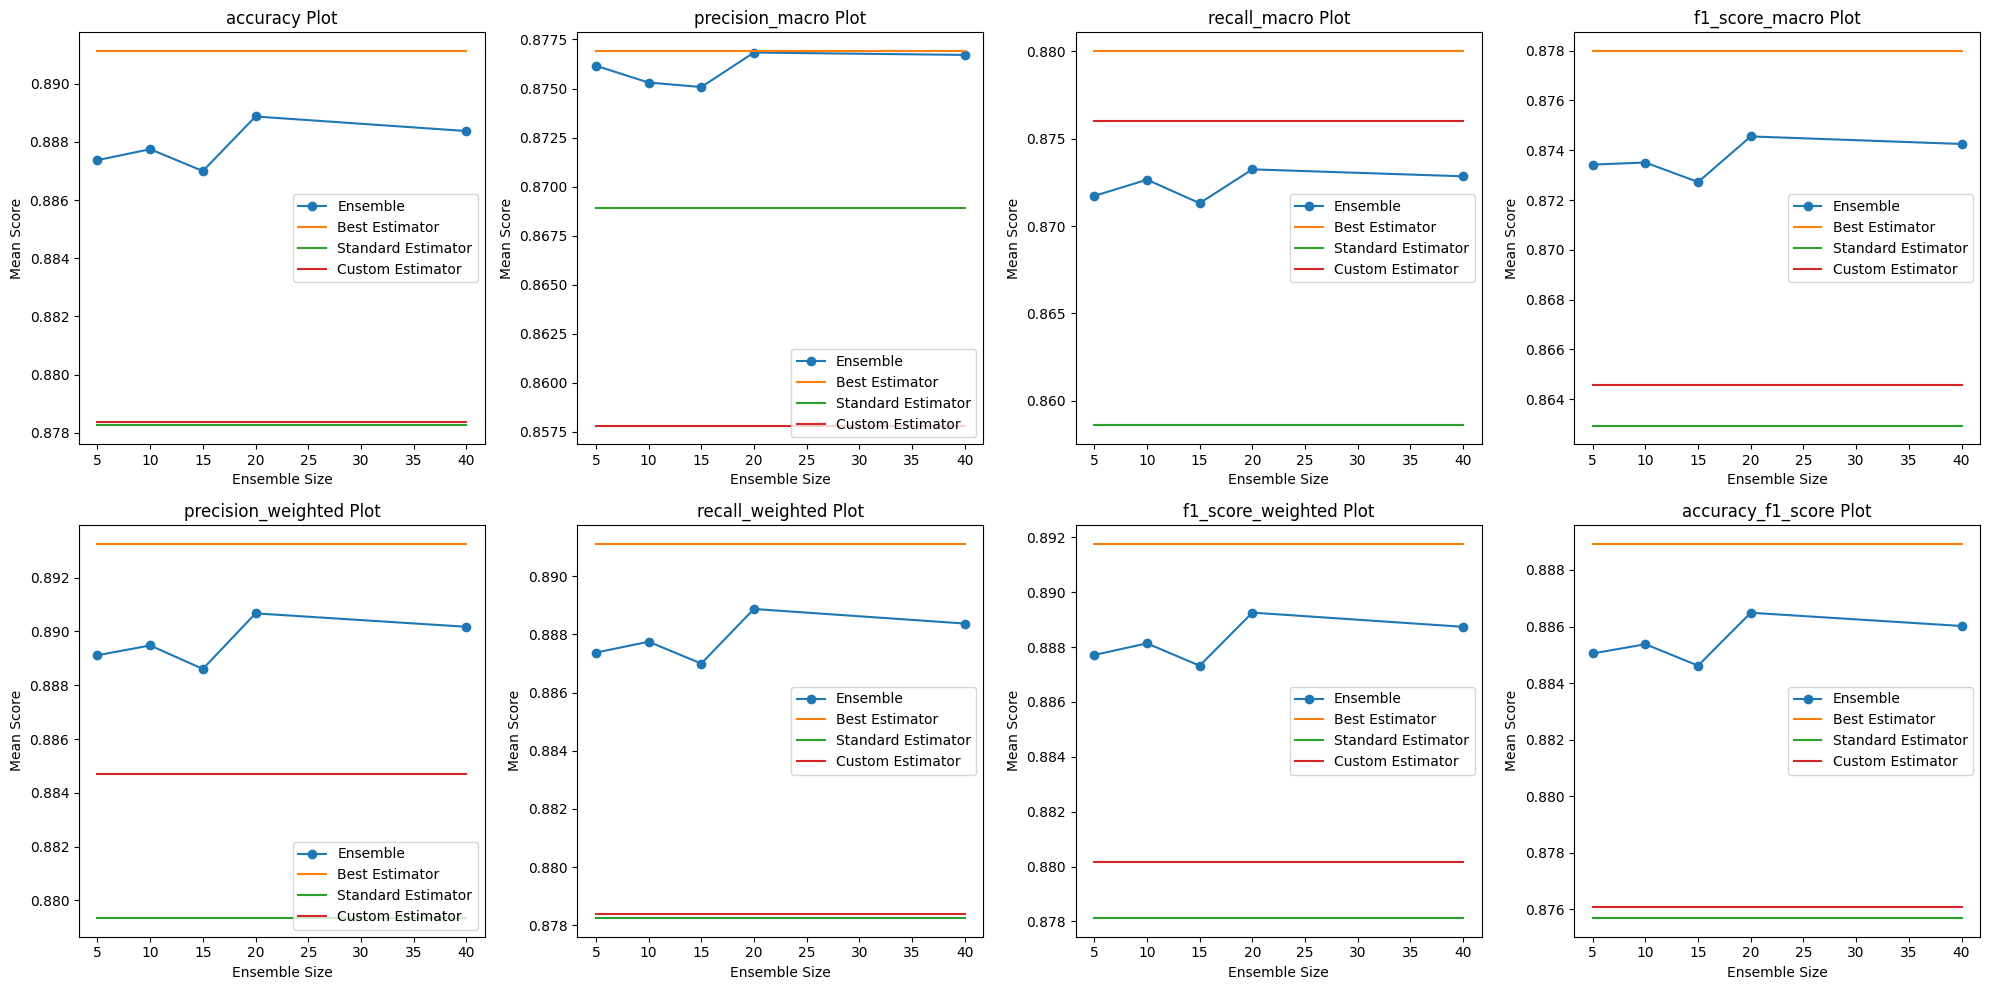

In our analysis, we compared four models: the standard model, the best model (found through random search), a custom model, and an ensemble model. Our focus was on their training data performance.

The best estimator, identified via random search, consistently outperformed the others. While the ensemble model achieved an accuracy of 0.887 at 20 estimators, the best estimator led with 0.89 accuracy. The standard and custom models performed notably worse, suggesting that systematic search was more effective than traditional modifications of a naive Bayes classifier.

Regarding F1-score, the best estimator again outshone the rest, reinforcing its effectiveness.

Our findings favor the best estimator as the optimal choice, a conclusion backed by additional reasons in our code documentation.

The table below details the best estimator's performance:

| Class    | Precision | Recall | F1-score | Support |
|:---------|-----------|--------|----------|---------|
| cs       | 0.85      | 0.90   | 0.87     | 639     |
| math     | 0.93      | 0.93   | 0.93     | 522     |
| physics  | 0.95      | 0.89   | 0.92     | 593     |
| stat     | 0.78      | 0.81   | 0.80     | 246     |
| Accuracy |           |        | 0.89     | 2000    |
| Macro Avg| 0.88      | 0.88   | 0.88     | 2000    |
| Weighted Avg | 0.89  | 0.89   | 0.89     | 2000    |


#### Performance on the Testing Data
The table shows the best estimator's high precision and recall across classes like cs, math, physics, and stat. Its effectiveness is evident in the physics class with an F1-score of 0.92. The overall accuracy of 0.89 and similar macro and weighted averages demonstrate its robustness and reliability across varied datasets.

---

# Coding Section

This notebook **does not** have all the code. Please refer to the attached files for the rest of the code. Additionally, if you require the cached data, please ensure that you have access to the relevant files.

Note: `imblearn` is an extension of sklearn.

In [1]:
import numpy as np
import pandas as pd
from text_flattener import TextFlattener # custom wrapper to fix compatibility issues
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score, \
    classification_report  # score metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate  # validation
from imblearn.pipeline import Pipeline  # container
import pickle  # used to load and save the code that takes hours to run
import matplotlib.pyplot as plt  # used for final plot

# hyperparameters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer  # preprocess
from imblearn.over_sampling import RandomOverSampler  # preprocess
from imblearn.under_sampling import RandomUnderSampler  # preprocess

# custom model
from naive_bayes import NaiveBayes  # please see the other files in the assignment to get this code
from sklearn.ensemble import BaggingClassifier

# custom project for determining amount of models to search in RandomSearch
from model_calculator import ModelCalculator

# to dedicate appropriate amount of cores to searching space
import multiprocessing

Sets the random seed of the entire script.

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
df = pd.read_csv("science_field_dataset.csv")

In [4]:
df.head()

,id,abstract,category
0,0,"Turing machines and G\""odel numbers are import...",cs
1,1,RNA-sequencing has revolutionized biomedical r...,stat
2,2,Queuing models provide insight into the tempor...,physics
3,3,"In a multiple-object auction, every bidder tri...",cs
4,4,In arXiv:1109.6438v1 [math.AG] we introduced a...,math


`id` column is superfluous and so will be dropped.

In [5]:
df.drop("id", axis=1, inplace=True)

In [6]:
df.shape

(10000, 2)

In [7]:
df["category"].value_counts()

cs         3192
physics    2967
math       2609
stat       1232
Name: category, dtype: int64

A fairly unequal distribution of the class labels means we should stratify the split.

In [8]:
X, y = np.array(df["abstract"]).reshape(-1, 1), np.array(df["category"])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=random_state)

We'll define a comprehensive parameter space that covers various aspects of text processing and model configuration. This includes experimenting with n-gram ranges in the count vectorizer to capture different levels of textual context, evaluating the impact of including or excluding common stop words, toggling binary frequency counts, and adjusting the normalization and idf components of the TF-IDF transformer. Additionally, we'll explore different resampling strategies to handle class imbalance and testing a range of values for the classifier's smoothing parameter, alpha. Such an extensive exploration is pivotal for optimising the classifier's performance on our specific dataset, ensuring that it learns effectively.

Note: `TextFlattener` simply resolves the shape incompatibility between BaggingClassifier and the pipeline, which is relevant later on.

In [9]:
pipeline = Pipeline([
    ("text_flattener", TextFlattener()),
    ("count_vectorizer", CountVectorizer()),
    ("tfidftransformer", TfidfTransformer()),
    ("resampler", None),
    ("naivebayes", NaiveBayes()),
])

In [10]:
param_space = {
    "count_vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3), (1, 4), (2, 2), (2, 3), (2, 4)],
    "count_vectorizer__stop_words": [None, "english"],
    "count_vectorizer__binary": [True, False],
    "tfidftransformer__norm": ["l2", "l1", None],
    "tfidftransformer__use_idf": [True, False],
    "tfidftransformer__smooth_idf": [True, False],
    "resampler": [None, RandomUnderSampler(random_state=random_state), RandomOverSampler(random_state=random_state)],
    "naivebayes__alpha": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
}

To optimise the evaluation of our classifiers, we have developed a custom scoring function, accuracy_f1_weighted_scorer, for use in the GridSearchCV process. This function assigns scores to models based on a weighted combination of accuracy and F1 score. Specifically, it prioritises accuracy, assigning five times more weight to improvements in accuracy than to improvements in the F1 score. For example, a 1% increase in accuracy contributes five points to the model's score, while the same increase in the F1 score adds just one point. This weighted scoring means that a model with 100% accuracy and 50% F1 score would be scored equivalently to one with 90% accuracy and 100% F1 score. Our goal with this method is to identify models that are accurate but also maintain some precision and recall, as indicated by the F1 score. The effect of this scoring bias can be visually understood through a [graph, as seen here](https://www.desmos.com/calculator/ioub2l2e85), where models with different accuracy and F1 combinations can be compared.

In [11]:
def accuracy_f1_weighted_scorer(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    acc_bias = 5  # will exchange 1 point of accuracy for 5 points of f1
    f1_bias = 1
    score = (acc_bias * acc + f1_bias * f1) / (acc_bias + f1_bias)
    return score

accuracy_f1_scorer = make_scorer(accuracy_f1_weighted_scorer)

We plan to utilise multiple scoring metrics to evaluate the models identified through our process. This multi-metric approach ensures a comprehensive assessment, capturing various performance aspects and providing a well-rounded view of each model's strengths and weaknesses.

In [12]:
scorers = {
    "accuracy": make_scorer(accuracy_score),
    "precision_macro": make_scorer(precision_score, average="macro", zero_division=0),
    "recall_macro": make_scorer(recall_score, average="macro", zero_division=0),
    "f1_score_macro": make_scorer(f1_score, average="macro", zero_division=0),
    "precision_weighted": make_scorer(precision_score, average="weighted", zero_division=0),
    "recall_weighted": make_scorer(recall_score, average="weighted", zero_division=0),
    "f1_score_weighted": make_scorer(f1_score, average="weighted", zero_division=0),
    "accuracy_f1_score": accuracy_f1_scorer,
}

Our pipeline has a vast parameter space with 7,056 unique combinations, derived from the product of different options in `param_space`. Given the extensive size of this space, conducting an exhaustive search with GridSearchCV might be time-prohibitive. To address this, we'll opt for a RandomSearch approach, which allows us to explore a subset of the total space more efficiently. Our goal is to achieve a high degree of confidence in our model selection. Specifically, we aim for a 99% probability of identifying a model that ranks within the top 1% of all possible combinations. We can utilise another project to determine the amount of models we need to search through.

In [13]:
model_calc = ModelCalculator(N=7056, t=1 / 100, g=99 / 100)
n_iter = model_calc.calculate_result()

In [14]:
n_iter

448

In [15]:
num_cores = multiprocessing.cpu_count()
cores_to_safely_use = max(1, round(num_cores * (2 / 3)))

In [16]:
run = False

In [17]:
# WARNING! Computationally expensive to run this cell, check for cached results first.

if run:
    random_search = RandomizedSearchCV(pipeline,
                                       param_space,
                                       n_iter=n_iter,
                                       scoring=scorers,
                                       n_jobs=cores_to_safely_use,
                                       refit="accuracy_f1_score",
                                       cv=5,
                                       verbose=2)
    random_search.fit(X_train, y_train)

    with open("cached_results/random_search_results.pkl", "wb") as file:
        pickle.dump(random_search, file)

In [18]:
with open("cached_results/random_search_results.pkl", "rb") as file:
    random_search_results = pickle.load(file)

Here are the best parameters for the pipeline.

In [19]:
for param, value in random_search_results.best_params_.items():
    print(f"{param}: {value}")
print(f"Custom Score: {random_search_results.best_score_:.3f}")

tfidftransformer__use_idf: False
tfidftransformer__smooth_idf: False
tfidftransformer__norm: l2
resampler: RandomOverSampler(random_state=42)
naivebayes__alpha: 0.01
count_vectorizer__stop_words: english
count_vectorizer__ngram_range: (1, 3)
count_vectorizer__binary: True
Custom Score: 0.889


In [20]:
pipeline.set_params(**random_search_results.best_params_)
naive_bayes_ensemble = BaggingClassifier(pipeline, n_jobs=cores_to_safely_use, random_state=random_state, verbose=2)

Combining multiple classifiers into an ensemble can often result in improved predictive accuracy over a single classifier. We plan to investigate this possibility to enhance our model's performance. The ensemble will be built using the best-performing model identified from our random search as the foundational model.

In [21]:
run = False

In [22]:
# WARNING! Computationally expensive to run this cell, check for cached results first.

if run:
    param_grid = {
        "n_estimators": [5, 10, 15, 20, 40]
    }

    ensemble_grid_search = GridSearchCV(estimator=naive_bayes_ensemble,
                                        param_grid=param_grid,
                                        scoring=scorers,
                                        refit="accuracy_f1_score",
                                        cv=5,
                                        n_jobs=None,  # for memory reasons, use n_jobs on ensemble itself
                                        verbose=2)
    ensemble_grid_search.fit(X_train, y_train)

    with open("cached_results/ensemble_grid_search_results.pkl", "wb") as file:
        pickle.dump(ensemble_grid_search, file)

In [23]:
with open("cached_results/ensemble_grid_search_results.pkl", "rb") as file:
    ensemble_grid_search_results = pickle.load(file)

In [24]:
naive_bayes_ensemble.set_params(**ensemble_grid_search_results.best_params_)

BaggingClassifier(estimator=Pipeline(steps=[('text_flattener', TextFlattener()),
                                            ('count_vectorizer',
                                             CountVectorizer(binary=True,
                                                             ngram_range=(1, 3),
                                                             stop_words='english')),
                                            ('tfidftransformer',
                                             TfidfTransformer(smooth_idf=False,
                                                              use_idf=False)),
                                            ('resampler',
                                             RandomOverSampler(random_state=42)),
                                            ('naivebayes',
                                             NaiveBayes(alpha=0.01))]),
                  n_estimators=20, n_jobs=4, random_state=42, verbose=2)

We are going to deploy a conventional Naive Bayes classifier to establish a baseline performance metric. This benchmark will allow us to measure the effectiveness of the superior model derived from GridSearch as well as that of an ensemble model with a differing number of `n_estimators`.

In [25]:
standard_pipeline = Pipeline([
    ("text_flattener", TextFlattener()),
    ("count_vectorizer", CountVectorizer()),
    ("naivebayes", NaiveBayes()),
])

standard_results = cross_validate(standard_pipeline, X_train, y_train, scoring=scorers, cv=5)

A bespoke Naive Bayes pipeline, designed based on intuitive reasoning for high performance, will be introduced. This will offer an interesting juxtaposition between expected outcomes and actual results.

In [26]:
custom_pipeline = Pipeline([
    ("text_flattener", TextFlattener()),
    ("count_vectorizer", CountVectorizer(stop_words="english", ngram_range=(1, 3))),
    ("tfidftransformer", TfidfTransformer(norm="l1", use_idf=True, smooth_idf=True)),
    ("resampler", RandomOverSampler(random_state=random_state)),
    ("naivebayes", NaiveBayes(alpha=0.01)),
])

custom_results = cross_validate(custom_pipeline, X_train, y_train, scoring=scorers, cv=5)

We will visualise the performance of each of the 4. By comparing the ensemble's performance across various metrics with that of the singular best estimator, we can determine if the ensemble approach offers significant advantages.

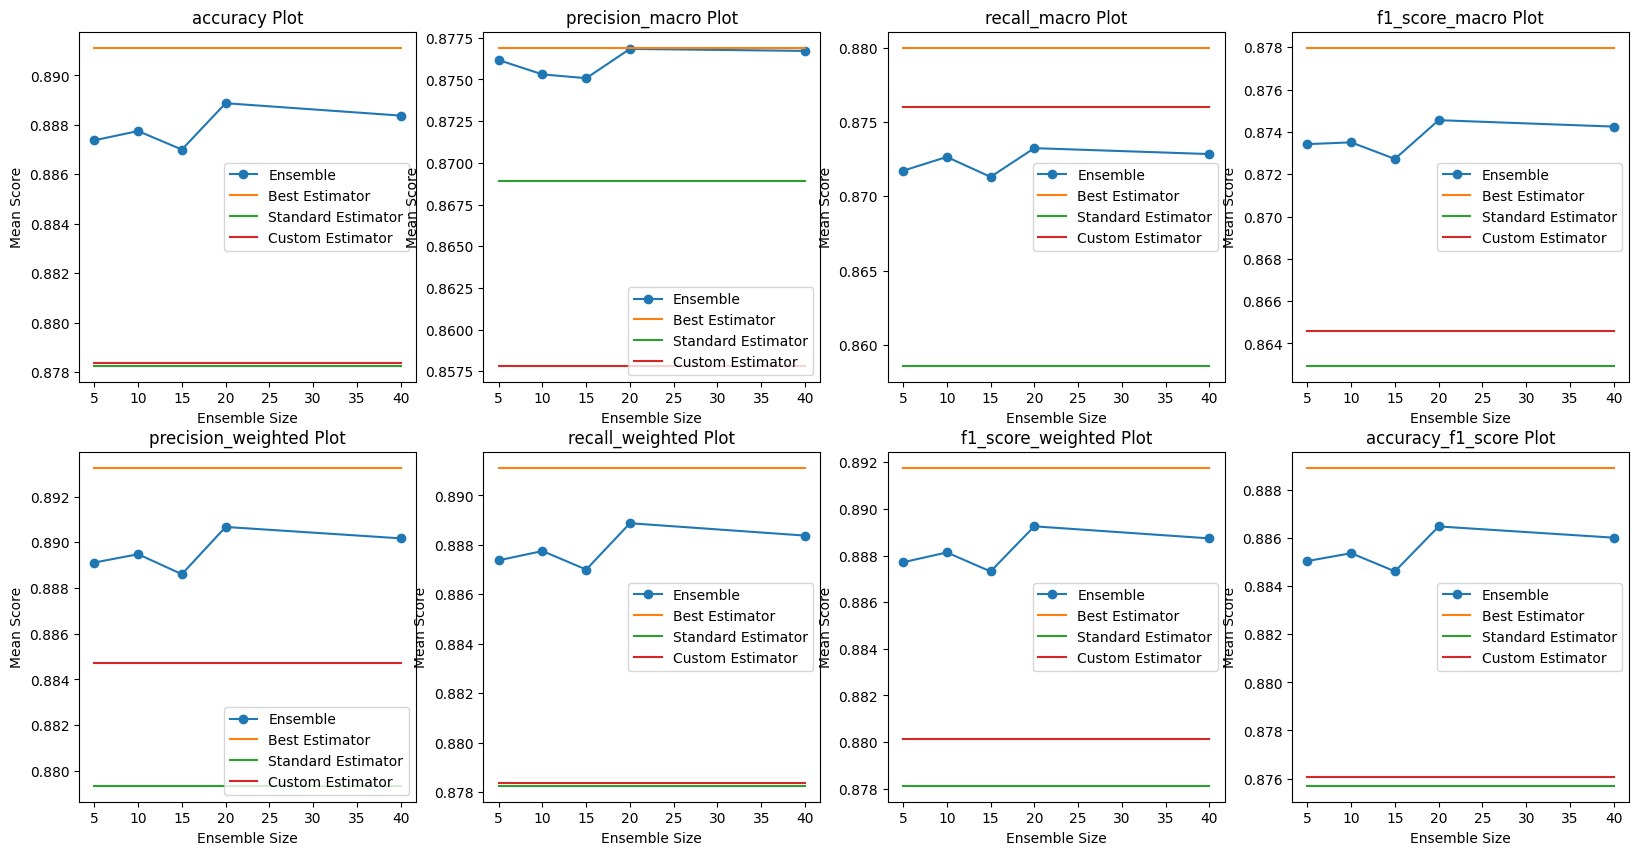

In [45]:
ensemble_plots = {}
best_estimator_plots = {}
standard_estimator_plots = {}
custom_estimator_plots = {}

ensemble_results = ensemble_grid_search_results.cv_results_
best_estimator_results = random_search_results.cv_results_

for score_title in scorers:
    num_estimators = len(ensemble_results["param_n_estimators"])
    ensemble_plots[score_title] = list(zip(ensemble_results["param_n_estimators"],
                                           ensemble_results[f"mean_test_{score_title}"]))
    best_estimator_plots[score_title] = list(zip(ensemble_results["param_n_estimators"],
                                                 [best_estimator_results[f"mean_test_{score_title}"][
                                                      random_search_results.best_index_]] * num_estimators))
    standard_estimator_plots[score_title] = list(zip(ensemble_results["param_n_estimators"],
                                                     [np.mean(standard_results[f"test_{score_title}"])] *
                                                     num_estimators))
    custom_estimator_plots[score_title] = list(zip(ensemble_results["param_n_estimators"],
                                                     [np.mean(custom_results[f"test_{score_title}"])] *
                                                     num_estimators))

num_cols = 4
num_rows = int(np.ceil(len(scorers) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axs = axs.flatten()

for i, score_title in enumerate(scorers):
    ensemble_data = ensemble_plots[score_title]
    best_estimator_data = best_estimator_plots[score_title]
    standard_estimator_data = standard_estimator_plots[score_title]
    custom_estimator_data = custom_estimator_plots[score_title]

    for plot_data, label, colour in zip(
            [ensemble_data, best_estimator_data, standard_estimator_data, custom_estimator_data],
            ["Ensemble", "Best Estimator", "Standard Estimator", "Custom Estimator"],
            ["r", "g", "b", "o"]):
        a, b = zip(*plot_data)
        if label == "Ensemble":
            axs[i].plot(a, b, label=label, marker="o")
        else:
            axs[i].plot(a, b, label=label)

    axs[i].set_title(f"{score_title} Plot")
    axs[i].set_xlabel("Ensemble Size")
    axs[i].set_ylabel("Mean Score")
    axs[i].legend()

plt.tight_layout()
plt.show()

Here are the scores attained by each version on the test set. Regardless of the scores obtained, I will be employing the `best_estimator` as the final classifier to use as so not to be biased.

In [28]:
naive_bayes_ensemble.fit(X_train, y_train)
y_prediction = naive_bayes_ensemble.predict(X_test)
classification_summary = classification_report(y_test, y_prediction)
print(classification_summary)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   28.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    9.4s finished


              precision    recall  f1-score   support

          cs       0.84      0.90      0.87       639
        math       0.94      0.92      0.93       522
     physics       0.94      0.89      0.92       593
        stat       0.80      0.78      0.79       246

    accuracy                           0.89      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.89      0.89      0.89      2000



In [29]:
pipeline.fit(X_train, y_train)
y_prediction = pipeline.predict(X_test)
classification_summary = classification_report(y_test, y_prediction)
print(classification_summary)

              precision    recall  f1-score   support

          cs       0.85      0.90      0.87       639
        math       0.93      0.93      0.93       522
     physics       0.95      0.89      0.92       593
        stat       0.78      0.81      0.80       246

    accuracy                           0.89      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.89      0.89      0.89      2000



In [30]:
standard_pipeline.fit(X_train, y_train)
y_prediction = standard_pipeline.predict(X_test)
classification_summary = classification_report(y_test, y_prediction)
print(classification_summary)

              precision    recall  f1-score   support

          cs       0.83      0.89      0.86       639
        math       0.91      0.93      0.92       522
     physics       0.94      0.89      0.91       593
        stat       0.83      0.75      0.79       246

    accuracy                           0.88      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.88      0.88      0.88      2000



In [31]:
custom_pipeline.fit(X_train, y_train)
y_prediction = custom_pipeline.predict(X_test)
classification_summary = classification_report(y_test, y_prediction)
print(classification_summary)

              precision    recall  f1-score   support

          cs       0.88      0.87      0.87       639
        math       0.92      0.93      0.93       522
     physics       0.95      0.88      0.91       593
        stat       0.74      0.86      0.79       246

    accuracy                           0.89      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.89      0.89      0.89      2000

